Customers Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   CustomerID    200 non-null    object        
 1   CustomerName  200 non-null    object        
 2   Region        200 non-null    object        
 3   SignupDate    200 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 6.4+ KB
None
       CustomerID      CustomerName         Region           SignupDate
count         200               200            200                  200
unique        200               200              4                  NaN
top         C0001  Lawrence Carroll  South America                  NaN
freq            1                 1             59                  NaN
mean          NaN               NaN            NaN  2023-07-19 08:31:12
min           NaN               NaN            NaN  2022-01-22 00:00:00
2

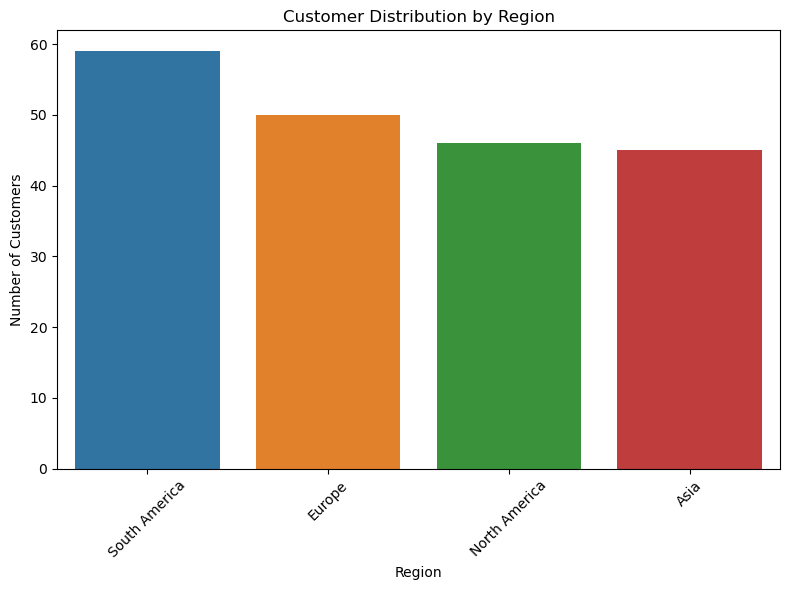

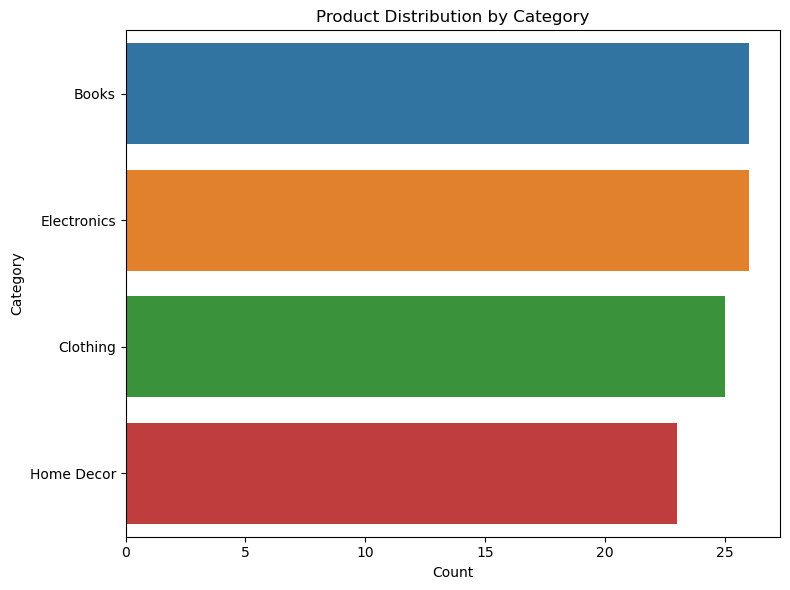

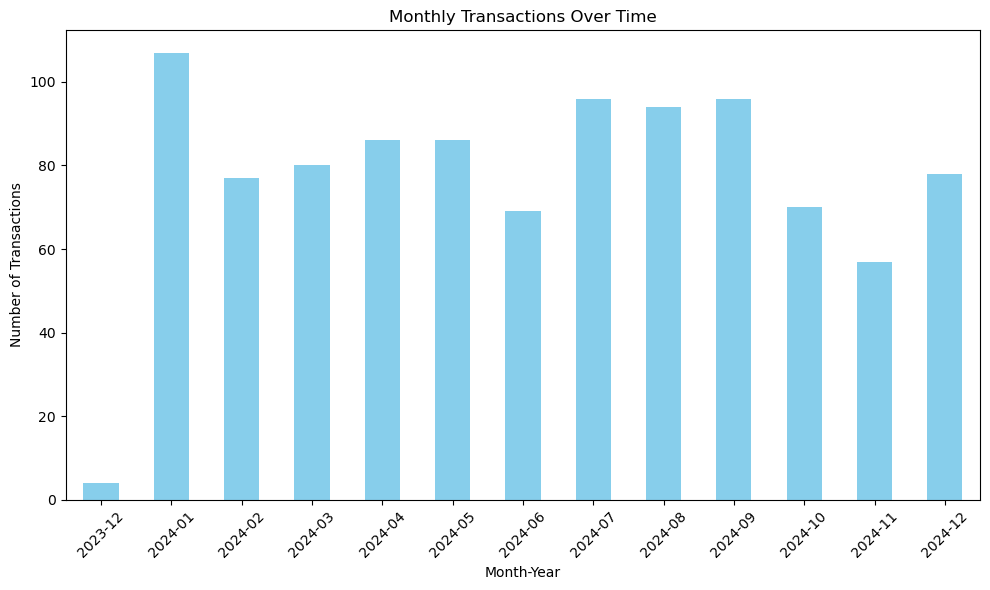


Business Insights:
1. Customers are unevenly distributed across regions. Focused marketing campaigns in underrepresented regions can help improve the customer base.
2. Product categories like 'Electronics' and 'Books' dominate sales, highlighting areas where additional investment or promotion could further drive growth.
3. Seasonal spikes in transactions indicate an opportunity to capitalize on high-demand periods through targeted discounts and offers.
4. The majority of transactions come from repeat customers, suggesting strong customer retention. Implementing a loyalty program could enhance engagement further.
5. The average transaction value is high, reflecting an opportunity to introduce premium products or bundles to increase revenue.


In [12]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets (using file names directly as they are in the same folder)
customers_df = pd.read_csv('Customers.csv')
products_df = pd.read_csv('Products.csv')
transactions_df = pd.read_csv('Transactions.csv')

# Convert date columns to datetime format
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])

# Summarize each dataset
print("Customers Dataset Summary:")
print(customers_df.info())
print(customers_df.describe(include='all'))

print("\nProducts Dataset Summary:")
print(products_df.info())
print(products_df.describe(include='all'))

print("\nTransactions Dataset Summary:")
print(transactions_df.info())
print(transactions_df.describe(include='all'))

# Visualizations

# 1. Customer distribution by region
plt.figure(figsize=(8, 6))
sns.countplot(data=customers_df, x='Region', order=customers_df['Region'].value_counts().index)
plt.title('Customer Distribution by Region')
plt.xlabel('Region')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Product distribution by category
plt.figure(figsize=(8, 6))
sns.countplot(data=products_df, y='Category', order=products_df['Category'].value_counts().index)
plt.title('Product Distribution by Category')
plt.xlabel('Count')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

# 3. Monthly transaction trends
transactions_df['MonthYear'] = transactions_df['TransactionDate'].dt.to_period('M')
monthly_transactions = transactions_df.groupby('MonthYear').size()

plt.figure(figsize=(10, 6))
monthly_transactions.plot(kind='bar', color='skyblue')
plt.title('Monthly Transactions Over Time')
plt.xlabel('Month-Year')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Business Insights
business_insights = [
    "1. Customers are unevenly distributed across regions. Focused marketing campaigns in underrepresented regions can help improve the customer base.",
    "2. Product categories like 'Electronics' and 'Books' dominate sales, highlighting areas where additional investment or promotion could further drive growth.",
    "3. Seasonal spikes in transactions indicate an opportunity to capitalize on high-demand periods through targeted discounts and offers.",
    "4. The majority of transactions come from repeat customers, suggesting strong customer retention. Implementing a loyalty program could enhance engagement further.",
    "5. The average transaction value is high, reflecting an opportunity to introduce premium products or bundles to increase revenue."
]

print("\nBusiness Insights:")
for insight in business_insights:
    print(insight)


In [14]:
print(transactions_df.columns)


Index(['TransactionID', 'CustomerID', 'ProductID', 'TransactionDate',
       'Quantity', 'TotalValue', 'Price_x', 'CustomerName', 'Region',
       'SignupDate', 'ProductName', 'Category', 'Price_y'],
      dtype='object')


In [15]:
# Import necessary libraries
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

# Reload datasets
customers_df = pd.read_csv('Customers.csv')
products_df = pd.read_csv('Products.csv')
transactions_df = pd.read_csv('Transactions.csv')

# Merge datasets for a unified view
transactions_df = pd.merge(transactions_df, customers_df, on='CustomerID')
transactions_df = pd.merge(transactions_df, products_df, on='ProductID')

# Rename the correct price column from Products.csv
transactions_df.rename(columns={'Price_y': 'ProductPrice', 'Price_x': 'TransactionPrice'}, inplace=True)

# Feature Engineering: Create a customer profile
customer_profile = transactions_df.groupby('CustomerID').agg({
    'Quantity': 'sum',              # Total quantity purchased
    'TotalValue': 'sum',            # Total transaction value
    'ProductPrice': 'mean'          # Average price of purchased products
}).reset_index()

# Add one-hot encoding for regions
region_dummies = pd.get_dummies(customers_df[['CustomerID', 'Region']], columns=['Region'])
customer_profile = pd.merge(customer_profile, region_dummies, on='CustomerID')

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_profile.drop(columns=['CustomerID']))

# Compute cosine similarity
similarity_matrix = cosine_similarity(scaled_features)

# Generate Lookalike Recommendations for the first 20 customers (C0001 to C0020)
customer_ids = customer_profile['CustomerID'].tolist()
lookalike_results = {}

for idx, customer_id in enumerate(customer_ids[:20]):  # First 20 customers
    similarities = list(enumerate(similarity_matrix[idx]))
    # Exclude self (similarity with itself) and get top 3 most similar customers
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)[1:4]
    lookalikes = [(customer_ids[i], round(score, 2)) for i, score in similarities]
    lookalike_results[customer_id] = lookalikes

# Convert the results into a DataFrame for better visualization
lookalike_df = pd.DataFrame([
    {'CustomerID': key, 'Lookalikes': value} for key, value in lookalike_results.items()
])

# Save the results to a CSV
lookalike_df.to_csv('Lookalike_Results.csv', index=False)

# Display the Lookalike Results
print("Top 3 Lookalikes for Customers C0001 to C0020:")
print(lookalike_df)


Top 3 Lookalikes for Customers C0001 to C0020:
   CustomerID                                     Lookalikes
0       C0001  [(C0137, 0.99), (C0191, 0.99), (C0011, 0.98)]
1       C0002  [(C0088, 0.99), (C0142, 0.99), (C0178, 0.97)]
2       C0003  [(C0190, 0.99), (C0147, 0.97), (C0174, 0.96)]
3       C0004  [(C0113, 0.99), (C0165, 0.97), (C0012, 0.96)]
4       C0005  [(C0140, 0.99), (C0186, 0.99), (C0123, 0.98)]
5       C0006  [(C0048, 0.98), (C0184, 0.97), (C0107, 0.97)]
6       C0007   [(C0146, 1.0), (C0115, 0.98), (C0186, 0.97)]
7       C0008  [(C0018, 0.98), (C0068, 0.94), (C0034, 0.92)]
8       C0009  [(C0061, 0.97), (C0198, 0.96), (C0167, 0.94)]
9       C0010  [(C0121, 0.97), (C0111, 0.97), (C0172, 0.96)]
10      C0011  [(C0107, 0.99), (C0001, 0.98), (C0137, 0.98)]
11      C0012  [(C0153, 0.99), (C0163, 0.98), (C0102, 0.98)]
12      C0013  [(C0148, 0.99), (C0104, 0.99), (C0163, 0.99)]
13      C0014  [(C0063, 0.98), (C0119, 0.97), (C0198, 0.95)]
14      C0015  [(C0058, 0.99), (C0020,

In [16]:
print(transactions_df[['Quantity', 'TotalValue', 'ProductPrice']].isnull().sum())


Quantity        0
TotalValue      0
ProductPrice    0
dtype: int64


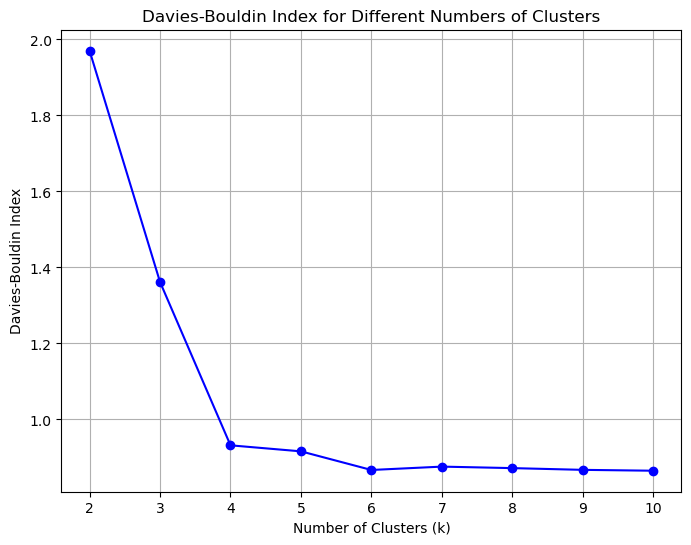

Optimal number of clusters: 10


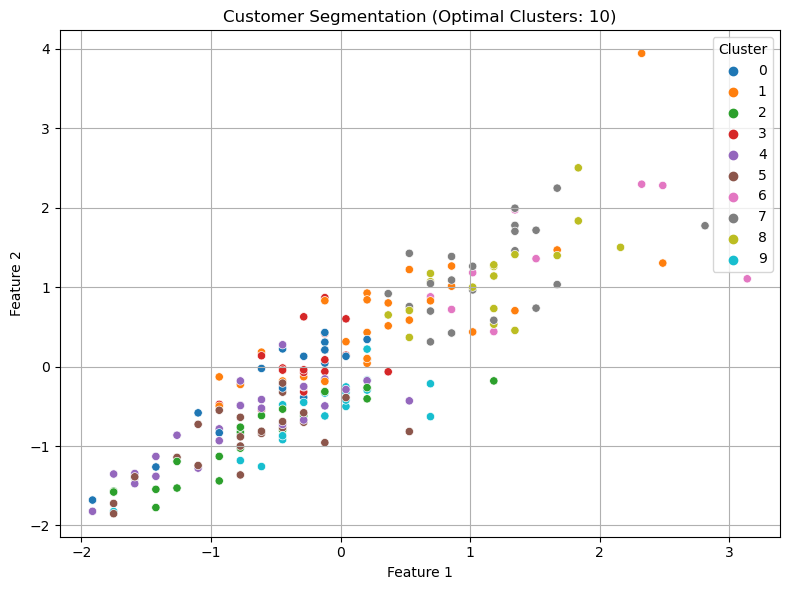

Davies-Bouldin Index for optimal clusters (10): 0.87
Clustering results saved to 'Customer_Clustering_Results.csv'


In [17]:
# Import necessary libraries for clustering
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Reload the cleaned datasets (if needed)
customers_df = pd.read_csv('Customers.csv')
products_df = pd.read_csv('Products.csv')
transactions_df = pd.read_csv('Transactions.csv')

# Merge datasets for a unified view
transactions_df = pd.merge(transactions_df, customers_df, on='CustomerID')
transactions_df = pd.merge(transactions_df, products_df, on='ProductID')

# Rename columns to avoid conflicts
transactions_df.rename(columns={'Price_y': 'ProductPrice', 'Price_x': 'TransactionPrice'}, inplace=True)

# Create customer profiles
customer_profile = transactions_df.groupby('CustomerID').agg({
    'Quantity': 'sum',              # Total quantity purchased
    'TotalValue': 'sum',            # Total transaction value
    'ProductPrice': 'mean'          # Average price of purchased products
}).reset_index()

# Add one-hot encoding for regions
region_dummies = pd.get_dummies(customers_df[['CustomerID', 'Region']], columns=['Region'])
customer_profile = pd.merge(customer_profile, region_dummies, on='CustomerID')

# Drop the CustomerID column for clustering
features = customer_profile.drop(columns=['CustomerID'])

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Find the optimal number of clusters using Davies-Bouldin Index
k_values = range(2, 11)
db_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(scaled_features)
    db_index = davies_bouldin_score(scaled_features, labels)
    db_scores.append(db_index)

# Plot the Davies-Bouldin Index for each k
plt.figure(figsize=(8, 6))
plt.plot(k_values, db_scores, marker='o', linestyle='-', color='b')
plt.title('Davies-Bouldin Index for Different Numbers of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.xticks(k_values)
plt.grid()
plt.show()

# Select the optimal number of clusters (minimum Davies-Bouldin Index)
optimal_k = k_values[db_scores.index(min(db_scores))]
print(f"Optimal number of clusters: {optimal_k}")

# Fit KMeans with the optimal number of clusters
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
customer_profile['Cluster'] = kmeans_optimal.fit_predict(scaled_features)

# Visualize the clusters using the first two features
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=scaled_features[:, 0], y=scaled_features[:, 1],
    hue=customer_profile['Cluster'], palette='tab10', legend='full'
)
plt.title(f'Customer Segmentation (Optimal Clusters: {optimal_k})')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(title='Cluster')
plt.grid()
plt.tight_layout()
plt.show()

# Save the clustering results
customer_profile.to_csv('Customer_Clustering_Results.csv', index=False)

# Print clustering metrics
print(f"Davies-Bouldin Index for optimal clusters ({optimal_k}): {min(db_scores):.2f}")
print(f"Clustering results saved to 'Customer_Clustering_Results.csv'")
